# Code Plus ou Moins d'origine

C'est pas cette partie là qui est intéressante pour nous.

In [1]:
import math
import numpy as np
import os
from music21 import converter
import matplotlib.pyplot as plt


def get_start_time(el, measure_offset, quantization):
    if (el.offset is not None) and (el.measureNumber in measure_offset):
        return int(math.ceil(((measure_offset[el.measureNumber] or 0) + el.offset) * quantization))
    # Else, no time defined for this element and the functino return None


def get_end_time(el, measure_offset, quantization):
    if (el.offset is not None) and (el.measureNumber in measure_offset):
        return int(
            math.ceil(((measure_offset[el.measureNumber] or 0) + el.offset + el.duration.quarterLength) * quantization))
    # Else, no time defined for this element and the functino return None


def get_pianoroll_part(part, quantization):
    # Get the measure offsets
    measure_offset = {None: 0}
    for el in part.recurse(classFilter=('Measure')):
        measure_offset[el.measureNumber] = el.offset
    # Get the duration of the part
    duration_max = 0
    for el in part.recurse(classFilter=('Note', 'Rest')):
        t_end = get_end_time(el, measure_offset, quantization)
        if (t_end > duration_max):
            duration_max = t_end
    # Get the pitch and offset+duration
    piano_roll_part = np.zeros((128, math.ceil(duration_max)))
    for this_note in part.recurse(classFilter=('Note')):
        note_start = get_start_time(this_note, measure_offset, quantization)
        note_end = get_end_time(this_note, measure_offset, quantization)
        piano_roll_part[this_note.pitch.midi, note_start:note_end] = 1  
        #print(this_note.pitch.midi,this_note.pitch)
    
    #for this_note in part.recurse(classFilter=('Instrument')):
    #    print(this_note)

    return piano_roll_part


# Here we provide a MIDI import function
def importMIDI(f):
    piece = converter.parse(f)
    all_parts = {}
    for part in piece.parts:
        try:
            track_name = part[0].bestName()
        except AttributeError:
            track_name = 'None'
        cur_part = get_pianoroll_part(part, 16);
        if (cur_part.shape[1] > 0):
            all_parts[track_name] = cur_part;
    print('Returning')
    return piece, all_parts


'''

Q-4.1 Import and plot some MIDI files

Based on the provided MIDI files (random subset of Beethoven tracks), try
to import, plot and compare different files

'''

root = r'D:\UNIVERSITE\Cours\Informatique Musicale\Machine Learning\Project\Midi'
track_path = os.path.join(root, '44swing5.mid')
piece, all_parts = importMIDI(track_path)
piece.plot()

print(all_parts['None'][36])
plt.figure(2)
plt.plot(all_parts['None'][36])



# TODO : 
# 1) Faire un bout de programme pour choisir l'instrument en fonction de la note.
# Kick, Clap, Snare, HHC, HHO, Random, Cymbales, Toms 
# 2) Regarder la quantification, et la mesure.
# 3) Loader automatiquement tout les fichiers. 
# http://web.mit.edu/music21/doc/usersGuide/usersGuide_14_timeSignatures.html
# http://web.mit.edu/music21/doc/moduleReference/moduleMeter.html#music21.meter.TimeSignature.beatSequence


ConverterException: File not found or no such format found for: D:\UNIVERSITE\Cours\Informatique Musicale\Machine Learning\Project\Midi\44swing5.mid

# Le code de Bibi
Ici, c'est le code du projet qui commence.

In [12]:
#Importing modules
import math
import numpy as np
import os
from music21 import converter
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.nan)

## Les fonctions d'Esling


In [13]:
# Defining functions
def get_start_time(el, measure_offset, quantization):
    if (el.offset is not None) and (el.measureNumber in measure_offset):
        return int(math.ceil(((measure_offset[el.measureNumber] or 0) + el.offset) * quantization))
    # Else, no time defined for this element and the functino return None


def get_end_time(el, measure_offset, quantization):
    if (el.offset is not None) and (el.measureNumber in measure_offset):
        return int(
            math.ceil(((measure_offset[el.measureNumber] or 0) + el.offset + el.duration.quarterLength) * quantization))
    # Else, no time defined for this element and the functino return None


def get_pianoroll_part(part, quantization):
    # Get the measure offsets
    measure_offset = {None: 0}
    for el in part.recurse(classFilter=('Measure')):
        measure_offset[el.measureNumber] = el.offset

    # Get the duration of the part
    duration_max = 0
    for el in part.recurse(classFilter=('Note')):
        t_end = get_end_time(el, measure_offset, quantization)
        if (t_end > duration_max):
            duration_max = t_end

    # Get the pitch and offset+duration
    piano_roll_part = np.zeros((math.ceil(duration_max+1)))
    for this_note in part.recurse(classFilter=('Note')):
        note_start = get_start_time(this_note, measure_offset, quantization)
        piano_roll_part[note_start] = 1  
        #print(this_note.offset)
        print(this_note.pitch, 'Beat : ', this_note.beat)
        #print(this_note.pitch.midi,this_note.pitch)
    print(switch_instrument(this_note.pitch.midi))
    
    return piano_roll_part, switch_instrument(this_note.pitch.midi)




## Les fonctions maisons

In [42]:
# Switch case pour convertir les notes midi en indices correspondant à nos instruments.
def get_instrument(midi):
    return {
        35 : lambda : 0, # Kick : 0
        36 : lambda : 0,
        37 : lambda : 1, # Snare : 1
        38 : lambda : 1,
        39 : lambda : 2, # Clap : 2
        40 : lambda : 1,
        41 : lambda : 5, # Tom : 5
        42 : lambda : 4, # HHC : 4
        43 : lambda : 5,
        44 : lambda : 4,
        45 : lambda : 5,
        46 : lambda : 3, # HHO : 3
        47 : lambda : 5,
        48 : lambda : 5,
        49 : lambda : 6, # Cymbales : 6
        50 : lambda : 5,
        51 : lambda : 6,
        52 : lambda : 6,
        53 : lambda : 6,
        55 : lambda : 6,
        57 : lambda : 6,
        59 : lambda : 6,
        91 : lambda : 1,
        93 : lambda : 1
    }.get(midi, lambda : 7)() # Perc : 7
   
# Fonction pour trouver la taille du clip midi en termes d'offset.
def get_midiclip_length(piece):
    midi_length = 0
    
    for part in piece.parts: 
        list_offsets = part.offsetMap()
        tmp = float(list_offsets[len(list_offsets)-1].offset)
        if tmp > midi_length:
            midi_length = tmp
            
    # Ceiling
    midi_length = math.ceil(midi_length) 
    
    # Quantizing to nearest measure depending on the time signature.
    midi_length += midi_length % piece.parts[0].timeSignature.numerator
    return midi_length


'''
Fonction pour trouver les notes d'un accord music21 (chord)
'''
def process_chord(piano_roll,this_chord):
    for this_note in this_chord:
        process_note(piano_roll,this_note)
        #print(get_instrument(this_note.pitch.midi))
        #print(this_chord.offset)
    
'''
Fonction qui associe une note à une activation dans piano_roll.
TODO : Remplir piano_roll en fonction de la note et de son offset. Retourner piano_roll
'''
def process_note(piano_roll,this_note):
        print(get_instrument(this_note.pitch.midi))
        print(this_note.offset)
    

'''
Renvoie un piano_roll du clip midi mis en forme par nos soins.
TODO:   Terminer process_note et process_chord.
        Plotter le piano_roll pour voir ce qui va et ne va pas.

'''
def get_pianoroll(piece):
    nb_instrument = 8
    quantification = 8
    nb_measure = 2
    
    midi_length = get_midiclip_length(piece)
    #print(midi_length)
    
    activation_matrix = np.zeros((nb_instrument,quantification**nb_mesures))
    
    for part in piece.parts:
        for this_note in part.recurse(classFilter=('Note', 'Chord')):
            if this_note.isChord == True:
                print('Chord')
                process_chord(activation_matrix, this_note)
                
            else:
                print('Note')
                process_note(activation_matrix, this_note)
                
            
    

    

# Here we provide a MIDI import function
def importMIDI(f):
    piece = converter.parse(f)
    keys = ['None','Kick', 'Snare', 'Clap', 'HHC', 'HHO', 'Tom', 'Cymbal', 'Perc']
    all_parts = {key : None for key in keys}
    #print(4,all_parts)
    get_pianoroll(piece)
    
#    for part in piece.parts:
#        try:
#            track_name = part[0].bestName()
#        except AttributeError:
#            track_name = 'None'
#        cur_part, track_name = get_pianoroll_part(part, 16);
#        if (cur_part.shape[0] > 0):
#            all_parts[track_name] = cur_part;

    print('Returning')
    return piece, all_parts

Note
0
0.0
Note
6
0.25
Note
4
0.5
Note
5
0.75
Note
4
1.0
Note
6
1.25
Note
4
1.5
Note
0
1.75
Chord
0
0.0
2.0
6
0.0
2.0
Note
4
2.25
Note
1
2.5
Note
4
2.75
Note
0
3.0
Note
6
3.25
Note
4
3.5
Note
5
3.75
Note
4
4.0
Note
6
4.25
Note
4
4.5
Note
0
4.75
Chord
0
0.0
5.0
6
0.0
5.0
Note
4
5.25
Note
1
5.5
Note
4
5.75
Note
5
6.0
Note
0
13.0
Note
6
13.25
Note
4
13.5
Note
5
13.75
Note
4
14.0
Note
6
14.25
Note
4
14.5
Note
0
14.75
Chord
0
0.0
15.0
6
0.0
15.0
Note
4
15.25
Note
1
15.5
Note
4
15.75
Note
0
16.0
Note
5
16.25
Note
4
16.5
Note
5
16.75
Note
4
17.0
Note
6
17.25
Note
4
17.5
Note
0
17.75
Note
5
18.0
Note
1
18.25
Note
5
18.5
Note
1
18.75
Note
5
19.0
Note
1
19.25
Note
0
26.0
Note
6
26.25
Note
4
26.5
Chord
5
0.0
26.75
7
0.0
26.75
Note
4
27.0
Note
6
27.25
Note
4
27.5
Note
0
27.75
Chord
0
0.0
28.0
6
0.0
28.0
Note
4
28.25
Note
1
28.5
Note
4
28.75
Note
0
29.0
Note
6
29.25
Note
4
29.5
Chord
5
0.0
29.75
7
0.0
29.75
Note
4
30.0
Note
6
30.25
Note
4
30.5
Note
0
30.75
Chord
6
0.0
31.0
0
0.0
31.0
Note
4
31.25
N

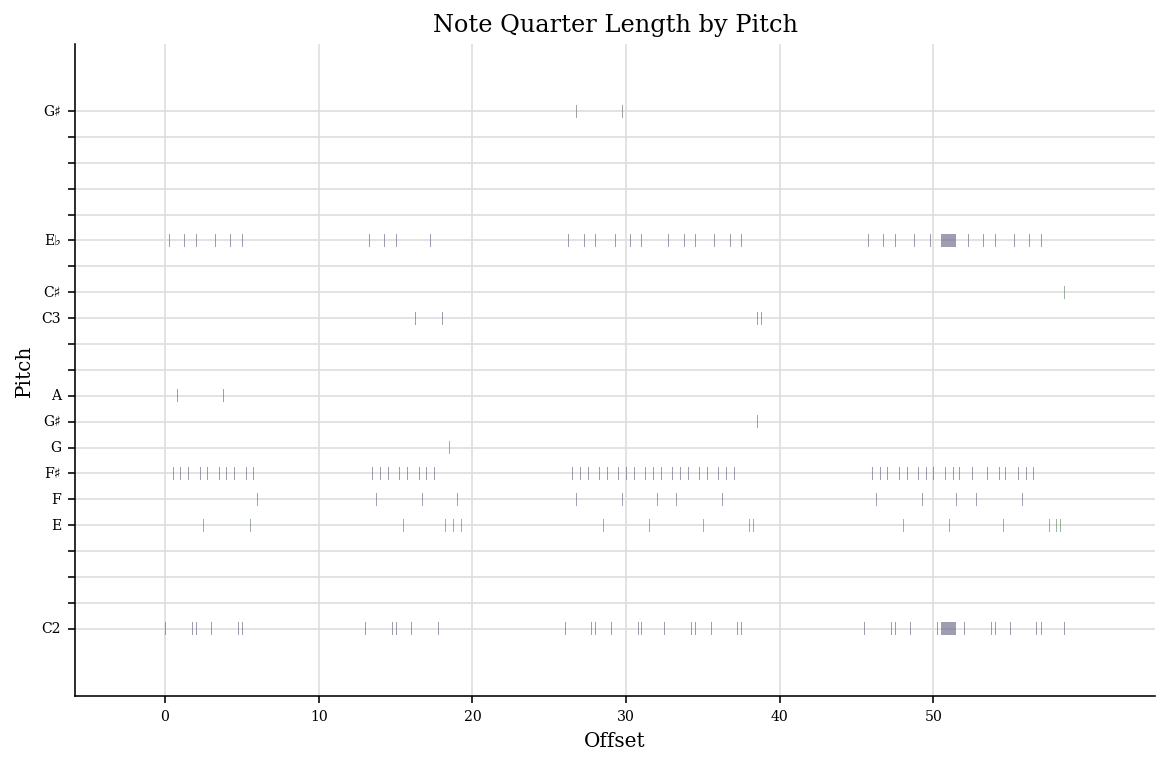

<Figure size 1080x360 with 0 Axes>

In [39]:
# MAIN

root = r'C:\Users\dell\Desktop\Datasets'
track_path = os.path.join(root,'a138fnk.mid')
#track_path = os.path.join(root,'128bald3.mid')
piece, all_parts = importMIDI(track_path)
piece.plot()
#piece.show('text')

#print(all_parts[list(all_parts)[1]])


plt.figure(2, figsize=[15,5])

#plt.plot(all_parts['Kick'])
#plt.plot(all_parts['Snare'])
#plt.plot(all_parts['HHC'])

print(piece.parts[0].metronomeMarkBoundaries())

In [47]:
quantification = 8
nb_mesures = 2

print(quantification**nb_mesures)

64
